# Neural Network model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.model_selection import TimeSeriesSplit
from itertools import product
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

## Data loading

In [2]:
df = pd.read_csv("data/final_data.csv")
df.dropna(inplace=True)
df.head()

,Tm,Year,PTS_1,VORP_1,PER_1,WS_1,PTS_2,VORP_2,PER_2,WS_2,...,NRtg_2,SRS_2,WinLoss_1,NRtg_1,SRS_1,Rest,B2B,distLB,distUB,WinLoss
0,BOS,1984,0.722218,1.445467,0.439962,1.151077,1.084341,1.733788,0.145440,0.984298,...,1.560378,1.631836,1.134881,1.120777,1.170642,1.244913,-0.368426,-0.359567,0.043129,0.756
1,NJN,1984,-0.663271,-0.349592,-0.982110,-0.497881,-0.305562,-0.929770,-1.083423,-1.080527,...,0.168776,0.223381,0.607876,0.581578,0.607197,1.244913,-0.881990,-0.736498,-0.606690,0.549
2,NYK,1984,-0.941947,-0.510126,-0.788466,-0.509214,0.405433,-0.385286,-0.783936,-0.415986,...,-0.661303,-0.552811,0.229672,0.519363,0.565542,-0.544649,0.401919,-0.657416,-0.641871,0.573
3,WSB,1984,0.433828,2.233541,2.424811,2.596040,-0.036195,0.468230,0.479706,0.680508,...,0.217604,0.272215,0.074670,-0.019837,0.043753,-0.544649,0.145138,-1.147874,-0.891759,0.427
4,ATL,1984,-0.340880,-0.977133,-1.989662,-1.319527,-1.051179,-1.400676,-1.759683,-1.664374,...,0.119947,0.207960,0.149071,-0.206483,-0.157948,-0.544649,0.915483,0.116833,-0.361622,0.488


In [3]:
df.columns

Index(['Tm', 'Year', 'PTS_1', 'VORP_1', 'PER_1', 'WS_1', 'PTS_2', 'VORP_2',
       'PER_2', 'WS_2', 'PTS_3', 'VORP_3', 'PER_3', 'WS_3', 'PTS_4', 'VORP_4',
       'PER_4', 'WS_4', 'PTS_5', 'VORP_5', 'PER_5', 'WS_5', 'WinLoss_3',
       'NRtg_3', 'SRS_3', 'WinLoss_2', 'NRtg_2', 'SRS_2', 'WinLoss_1',
       'NRtg_1', 'SRS_1', 'Rest', 'B2B', 'distLB', 'distUB', 'WinLoss'],
      dtype='object')

(array([ 13.,  52., 119., 115., 138., 238., 165., 142.,  44.,  10.]),
 array([0.106 , 0.1844, 0.2628, 0.3412, 0.4196, 0.498 , 0.5764, 0.6548,
        0.7332, 0.8116, 0.89  ]),
 <BarContainer object of 10 artists>)

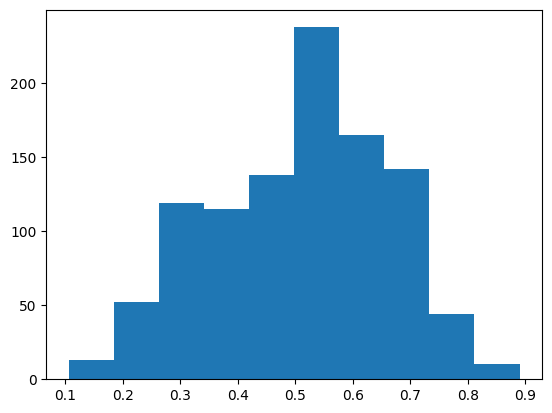

In [4]:
plt.hist(df.WinLoss)

## First Neural Network - Hand chosen hyperparameters

In [5]:
# Train Validation Test Split 

train_df = df[(df.Year <= 2005)]
y_train = np.array(train_df.WinLoss)
X_train = train_df.drop(["WinLoss", "Year", "Tm"], axis = 1)

val_df = df[(df.Year > 2005) & (df.Year <= 2013)]
y_val = np.array(val_df.WinLoss)
X_val = val_df.drop(["WinLoss", "Year", "Tm"], axis = 1)

test_df = df[(df.Year >= 2014)]
y_test = np.array(test_df.WinLoss)
X_test = test_df.drop(["WinLoss", "Year", "Tm"], axis = 1)

In [6]:
class LearningRateLogger(tf.keras.callbacks.Callback):
        def on_epoch_begin(self, epoch, logs=None):
            lr = self.model.optimizer._decayed_lr(tf.float32).numpy()
            print(f"Learning rate before epoch {epoch}: {lr}")


def train_nn(X_train, y_train, X_val, y_val, lr, epoch, batch_size):
    
    n = 33

    model = models.Sequential()

    model.add(layers.Dense(32, activation='relu', input_shape=(n,), kernel_regularizer=regularizers.l1(l1=0)))
    model.add(layers.Dense(16, activation='relu'))
    #model.add(layers.Dropout(0.2))
    model.add(layers.Dense(8, activation='relu'))
    #model.add(layers.Dense(4, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    
    # Define the learning rate schedule
    initial_learning_rate = lr
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=500,
        decay_rate=0.96,
        staircase=True)

    # Create an optimizer with the learning rate schedule
    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=lr_schedule)

    model.compile(optimizer=optimizer, 
                loss='mean_squared_error', 
                metrics=['mean_absolute_error'])
    
    history = model.fit(X_train, y_train, epochs=epoch, batch_size=batch_size, validation_data=(X_val, y_val), 
                        callbacks=[LearningRateLogger()])

    
    return model, history

def plot_history(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(1, len(train_loss) + 1)

    plt.plot(epochs_range, train_loss, label='Training loss')
    plt.plot(epochs_range, val_loss, label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


Learning rate before epoch 0: 0.0010000000474974513
Epoch 1/10
533/533 [==============================] - 0s 620us/step - loss: 0.0452 - mean_absolute_error: 0.1697 - val_loss: 0.0410 - val_mean_absolute_error: 0.1626
Learning rate before epoch 1: 0.0009600000339560211
Epoch 2/10
533/533 [==============================] - 0s 467us/step - loss: 0.0376 - mean_absolute_error: 0.1559 - val_loss: 0.0359 - val_mean_absolute_error: 0.1537
Learning rate before epoch 2: 0.0009216000325977802
Epoch 3/10
533/533 [==============================] - 0s 506us/step - loss: 0.0328 - mean_absolute_error: 0.1467 - val_loss: 0.0328 - val_mean_absolute_error: 0.1485
Learning rate before epoch 3: 0.000884735956788063
Epoch 4/10
533/533 [==============================] - 0s 462us/step - loss: 0.0298 - mean_absolute_error: 0.1408 - val_loss: 0.0308 - val_mean_absolute_error: 0.1449
Learning rate before epoch 4: 0.0008493465138599277
Epoch 5/10
533/533 [==============================] - 0s 465us/step - loss: 0

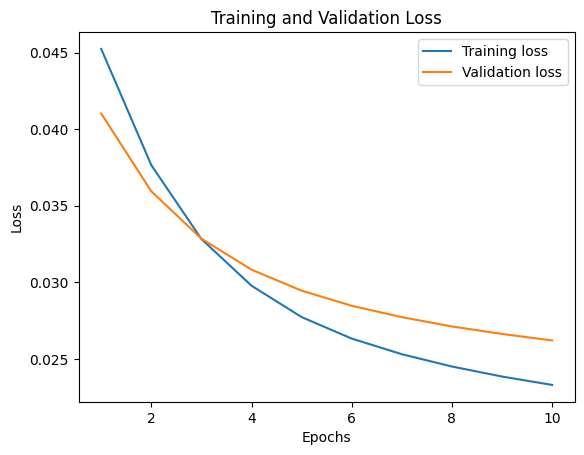

In [7]:
lr = 0.001
epoch = 10
batch_size = 1
model, history= train_nn(X_train, y_train, X_val, y_val, lr, epoch, batch_size)
plot_history(history)

## Neural Network - Grid Search

In [8]:
first_df = df[(df.Year <= 2013)]
y_train = np.array(first_df.WinLoss)
X_train = first_df.drop(["WinLoss", "Year", "Tm"], axis = 1)
second_df = df[(df.Year >= 2014)]
y_test = np.array(second_df.WinLoss)
X_test = second_df.drop(["WinLoss", "Year", "Tm"], axis = 1)

In [9]:
# Model building function
def build_model(n_layers, dropout_rate, activation, optimizer_name, learning_rate, decay_steps):
    tf.random.set_seed(1) 
    # Model architecture
    input_shape = 33
    model = models.Sequential()
    model.add(layers.Dense(16, activation='relu', input_shape=(input_shape,)))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(8, activation='relu'))
    if n_layers >=3:
         model.add(layers.Dense(4, activation='relu'))
    if n_layers >=4:
        model.add(layers.Dense(4, activation='relu'))
    model.add(layers.Dense(1, activation=activation))

    # Optimizer design
    if optimizer_name=='sgd':
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            learning_rate,
            decay_steps=decay_steps,
            decay_rate=0.96,
            staircase=True)
        optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=lr_schedule)
    else:
        optimizer = 'adam'
        
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])

    return model


In [464]:
param_grid = {
    'n_layers': [2, 3],
    'dropout_rate': [0.0, 0.1],
    'activation' : ['relu', 'sigmoid'],
    'batch_size': [8, 16, 32],
    'epoch': [10, 20],
    'optimizer_name': ['adam', 'sgd'],
    'learning_rate' : [0.1, 0.01, 0.001,],
    'decay_steps' : [1000, 10000, 100000]
}

param_grid_example = {
    'n_layers': [2],
    'dropout_rate': [0.0],
    'activation' : ['relu'],
    'batch_size': [1],
    'epoch': [10, 20],
    'optimizer_name': ['sgd'],
    'learning_rate' : [0.1, 0.01, 0.001,],
    'decay_steps' : [100, 500, 1000, 2000]
}

# Time series cross-validation setup
tscv = TimeSeriesSplit(n_splits=4, test_size=150, gap = 0)

# Convert the dictionary to a list of all combinations
param_combinations = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]

res = []

# Grid search loop
for params in param_combinations:

    model = build_model(params['n_layers'], params['dropout_rate'], params['activation'],
                        params['optimizer_name'], params['learning_rate'], params['decay_steps'])
    rmse = []
    iteration = 5
    for train_index, test_index in tscv.split(X_train):
        
        cv_train, cv_val = X_train.iloc[train_index], X_train.iloc[test_index]
        cv_y_train, cv_y_val = y_train[train_index], y_train[test_index]

        model.fit(cv_train, cv_y_train, validation_data=(cv_val, cv_y_val), 
                  epochs=params['epoch'], batch_size=params['batch_size'], verbose=0)
        rmse.append(iteration*np.sqrt(mean_squared_error(model.predict(cv_val), cv_y_val)))
        iteration += 1
    res.append((params, np.mean(rmse)))

5/5 [==============================] - 0s 619us/step


In [465]:
# Find the best hyperparameters
best_params = max(res, key=lambda x: x[1])[0]
best_rmse = max(res, key=lambda x: x[1])[1]
print('Best validation RMSE achieved:', best_rmse)
print('Best hyperparameters:', best_params)

Best validation RMSE achieved: 3.4489415697015646
Best hyperparameters: {'n_layers': 2, 'dropout_rate': 0.0, 'activation': 'relu', 'batch_size': 8, 'epoch': 20, 'optimizer_name': 'adam', 'learning_rate': 0.01, 'decay_steps': 10000}


## Get predictions with final NN model

In [10]:
best_params = {'n_layers': 2, 
               'dropout_rate': 0.0, 
               'activation': 'relu', 
               'batch_size': 8, 
                'epoch': 20, 
                'optimizer_name': 'adam', 
                'learning_rate': 0.01, 
                'decay_steps': 10000}

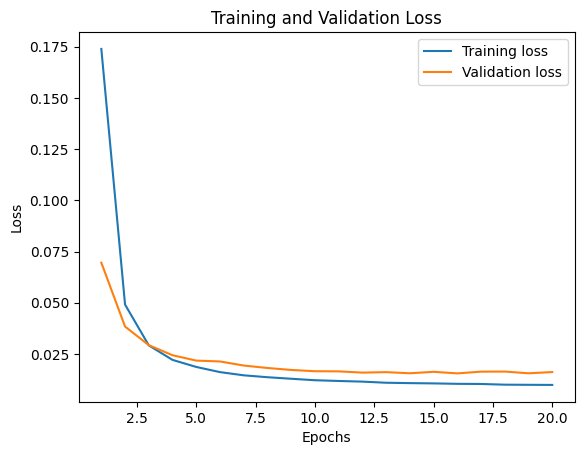

9/9 [==============================] - 0s 539us/step
R2 score of the train set : 0.3905490932609086
R2 score of the test set : 0.006785127431557347
MAE score of the train set : 0.07538771918471358
MAE score of the test set : 0.09867488881459474


In [12]:
#tf.random.set_seed(1)

model = build_model(best_params['n_layers'], best_params['dropout_rate'], best_params['activation'],
                       best_params['optimizer_name'], best_params['learning_rate'], best_params['decay_steps'])

#model = build_model(3, best_params['dropout_rate'], 'relu', params['optimizer_name'], 0.01, 1000)

history = model.fit(X_train, y_train, epochs=best_params['epoch'], batch_size=best_params['batch_size'], 
                    verbose=0, validation_data=(X_test, y_test))

plot_history(history)

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

print(f"R2 score of the train set : {r2_score(pred_train, y_train)}")
print(f"R2 score of the test set : {r2_score(pred_test, y_test)}")
print(f"MAE score of the train set : {mean_absolute_error(pred_train, y_train)}")
print(f"MAE score of the test set : {mean_absolute_error(pred_test, y_test)}")

In [24]:
# Final prediction df 
test = df.copy()[df['Year'] > 2013]
pred_df = test.copy()[['Year', 'Tm', 'WinLoss']].rename(columns = {'WinLoss': 'Real'})
pred_df['Pred'] = pred_test
pred_df['Real'] = round(pred_df['Real'] * 82)
pred_df['Pred'] = pred_df['Pred'] * 82
pred_df

,Year,Tm,Real,Pred
801,2014,BOS,25.0,33.891903
802,2014,NYK,37.0,37.231163
803,2014,ATL,38.0,49.330227
804,2014,CLE,33.0,33.250984
805,2014,DET,29.0,40.724442
...,...,...,...,...
1086,2023,MEM,51.0,48.830418
1087,2023,OKC,40.0,32.531612
1088,2023,BRK,45.0,52.153572
1089,2023,NOP,42.0,34.577541


In [26]:
pred_df.to_csv('data/pred_test_NN.csv', index = None)